In [51]:
import numpy as np
import pandas as pd

from collections import Counter

from scipy.stats import skew
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [52]:
data = pd.read_csv('TheRealData.csv')

In [53]:
data

,cc_num,merchant,amt,lat,long,merch_lat,merch_long,is_fraud,cc_time_diff,merch_time_diff,merch_distance_diff,distance_diff
0,0.005929,0.005763,49.25,43.0048,-108.8964,42.028563,-108.704803,0,31617.0,348064.0,179.890294,0.0
1,0.005929,0.018998,72.81,43.0048,-108.8964,43.276726,-109.182729,0,50071.0,898145.0,118.647789,0.0
2,0.005929,0.001604,3.06,43.0048,-108.8964,42.380831,-109.603971,0,13391.0,651248.0,81.728558,0.0
3,0.005929,0.002684,18.28,43.0048,-108.8964,43.858421,-109.210773,0,30407.0,412183.0,127.802964,0.0
4,0.005929,0.002684,104.67,43.0048,-108.8964,43.058281,-109.651038,0,9137.0,196323.0,95.805075,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1294995,0.003885,0.001659,60.47,41.1730,-89.2187,40.475395,-89.076105,0,30740.0,14963459.0,27.148187,0.0
1294996,0.003885,0.005684,74.29,41.1730,-89.2187,40.743634,-89.553379,0,12962.0,8087050.0,116.850835,0.0
1294997,0.003885,0.017332,246.56,41.1730,-89.2187,40.215418,-88.682562,0,7618.0,20897804.0,71.699381,0.0
1294998,0.003885,0.008239,2.62,41.1730,-89.2187,40.762861,-88.744967,0,18989.0,10294427.0,33.539822,0.0


In [54]:
X = data.drop(['is_fraud'], axis=1)
Y = data['is_fraud']

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=27)

In [56]:
from sklearn.tree import DecisionTreeClassifier

dcstree = DecisionTreeClassifier(random_state=42)
dcstree.fit(X_train, Y_train)

Y_pred = dcstree.predict(X_test)

<AxesSubplot:>

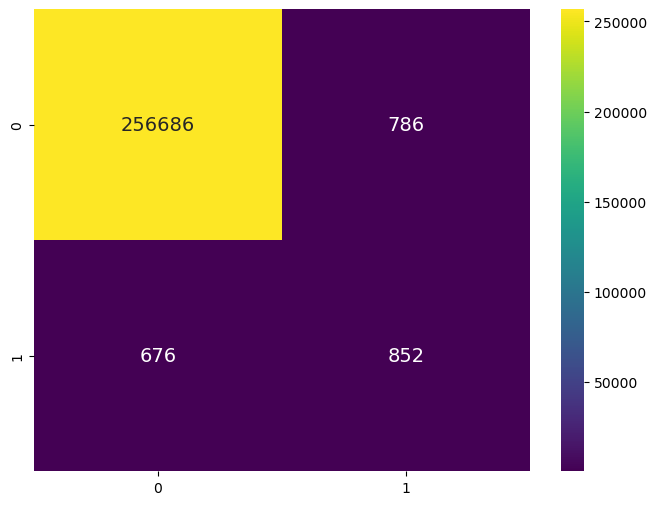

In [57]:
fig = plt.figure(figsize=(8,6))
cfs_matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cfs_matrix, cmap='viridis', annot=True, fmt='d', annot_kws=dict(fontsize=14))

In [58]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257472
           1       0.52      0.56      0.54      1528

    accuracy                           0.99    259000
   macro avg       0.76      0.78      0.77    259000
weighted avg       0.99      0.99      0.99    259000



In [59]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy={1:48050}, random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train.astype('float'), Y_train)
print("Before SMOTE:", Counter(Y_train))
print("After SMOTE:", Counter(y_train_smote))

Before SMOTE: Counter({0: 1030104, 1: 5896})
After SMOTE: Counter({0: 1030104, 1: 48050})


In [60]:
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [62]:
Y_pred = model.predict(X_test)

print(classification_report(Y_pred, Y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257207
           1       0.63      0.54      0.58      1793

    accuracy                           0.99    259000
   macro avg       0.82      0.77      0.79    259000
weighted avg       0.99      0.99      0.99    259000



In [63]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split
              }

print(random_grid)

{'n_estimators': [50, 100, 150, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [2, 5, 10]}


In [64]:
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score, greater_is_better=True, pos_label=1)

In [67]:
# Uncomment lines to run this code, this can be 

from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 5,
                               cv = 5,
                               verbose=2,
                               random_state=42
                              )

#Fit and show the best parameters
rf_random.fit(X_train, Y_train)
print(rf_random.best_estimator_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [28]:
import pickle

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
